In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

# validation modules
import experiment
import metrics

# requires cleanair
sys.path.append("../containers")
from cleanair.models import ModelData

In [2]:
# read experiment from file
name = 'basic'
cluster = 'laptop'
exp = experiment.experiment_from_dir(name, cluster)

In [3]:
# load the data_model objects
secret_fp = "../terraform/.secrets/db_secrets.json"
model_data_list = []
for data_config in exp.data_config:
    model_data = ModelData(config=data_config, secretfile=secret_fp)
    model_data_list.append(model_data)

In [4]:
# get a list of model data objects with updated prediction columns
updated_preds = []


for index, row in exp.experiment_df.iterrows():
    row = exp.experiment_df.loc[index]
    pid = row['param_id']
    model = row['model_name']
    did = row['data_id']
#     y_test = np.load(exp.data_config[did]['y_test_fp'])
    Y_pred = np.load(row['y_pred_fp'])
    
    # look at shapes
    data_config = exp.data_config[did]
    x_test = np.load(data_config['x_test_fp'])
    y_test = np.load(data_config['y_test_fp'])
    print("Xs :", x_test.shape)
    print("Ys :", y_test.shape)
    
    # update model_data
    normalised_df = model_data_list[did].normalised_pred_data_df.copy()
    predict_data_dict = model_data_list[did].get_pred_data_arrays(return_y=True).copy()
    
    # Create new dataframe with predictions
    predict_df = pd.DataFrame(index=predict_data_dict['index'])
    print("Pred index shape:", predict_df.shape)
    print("Y pred shape:", Y_pred[:, 0].shape)
    predict_df['predict_mean'] = Y_pred[:, 0]
    predict_df['predict_var'] = Y_pred[:, 1]
    predict_df['fit_start_time'] = exp.data_config[did]['pred_start_date']
    predict_df['tag'] = 0
    
    normalised_pred_data_df = pd.concat([model_data_list[did].normalised_pred_data_df, predict_df], axis=1, ignore_index=False)
    print(normalised_pred_data_df.sample(3))
    updated_preds.append(normalised_pred_data_df)
    

Xs : (2918, 143)
Ys : (2918, 1)
Pred index shape: (2918, 0)
Y pred shape: (2918,)
                                  point_id measurement_start_utc source  \
4071  f75378a6-389c-4247-acff-f7cddda7a848   2019-11-03 15:00:00   laqn   
1875  4a6cd532-62ef-4555-aedb-8e522d05ab76   2019-11-03 03:00:00   laqn   
5098  63266eab-400d-4421-8ebe-8243a95a5243   2019-11-03 10:00:00   laqn   

                                             location_x       lon        lat  \
4071  0101000020e61000003ebb86e64d94d6bf02f7677c9fc5... -0.352802  51.543930   
1875  0101000020e61000003eec8502b68361bf9032e202d0c4... -0.002138  51.537598   
5098  0101000020e61000006d718dcf64ffc83f3909a52f84ba...  0.195294  51.457159   

      value_1000_avg_min_width  value_1000_avg_ratio_avg  \
4071                 11.154446                  0.474338   
1875                 13.159341                  0.835119   
5098                 12.838983                  0.416274   

      value_1000_building_height  value_1000_flat  ... 

[3 rows x 296 columns]


In [45]:
i = 2
preds = updated_preds[i]
preds['measurement_start_utc'] = pd.to_datetime(preds['measurement_start_utc'])
gb = preds.groupby('point_id')
print(preds.columns)

Index(['point_id', 'measurement_start_utc', 'source', 'location_x', 'lon',
       'lat', 'value_1000_avg_min_width', 'value_1000_avg_ratio_avg',
       'value_1000_building_height', 'value_1000_flat',
       ...
       'value_10_max_flow_count_norm', 'value_10_max_occupancy_count_norm',
       'value_10_max_occupancy_percentage_norm',
       'value_10_total_flow_count_norm', 'value_10_total_occupancy_count_norm',
       'value_10_total_occupancy_percentage_norm', 'predict_mean',
       'predict_var', 'fit_start_time', 'tag'],
      dtype='object', length=296)


In [46]:
def plot_pretty_timeseries(time, series, ax, sigmas=None, locator=dates.DayLocator(interval=1)):
    ax.plot_date(time, series, ',', linestyle='-')
    ax.xaxis.grid(True, which="major")
#     ax.xaxis.set_major_locator(locator)
#     ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%m'))
    ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
    
    if not sigmas is None:
        factor = 2
        y_min = series - factor*np.sqrt(sigmas)
        y_max = series + factor*np.sqrt(sigmas)
        ax.fill_between(time, y_min, y_max, color='orange', alpha=0.5)
        
        
    return ax

times: (24,)
means: (24,)
sigmas: (24,)


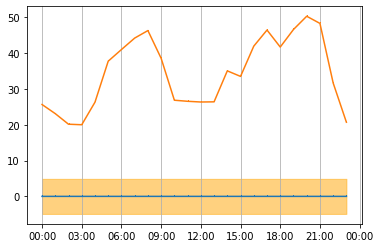

times: (24,)
means: (24,)
sigmas: (24,)


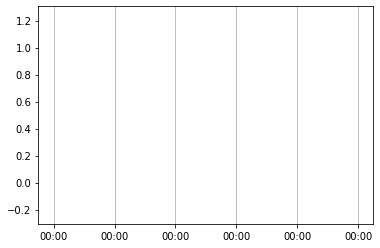

times: (24,)
means: (24,)
sigmas: (24,)


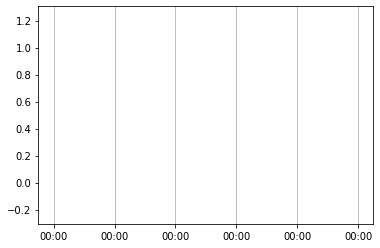

times: (24,)
means: (24,)
sigmas: (24,)


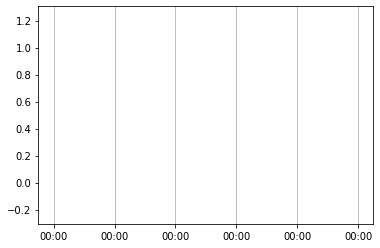

times: (24,)
means: (24,)
sigmas: (24,)


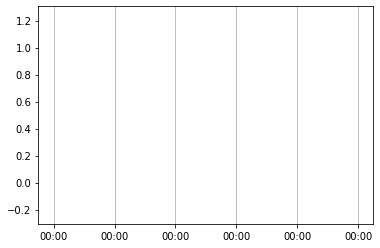

times: (24,)
means: (24,)
sigmas: (24,)


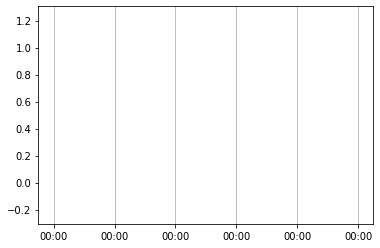

times: (24,)
means: (24,)
sigmas: (24,)


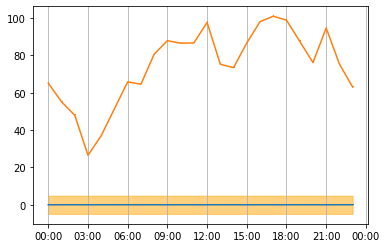

times: (24,)
means: (24,)
sigmas: (24,)


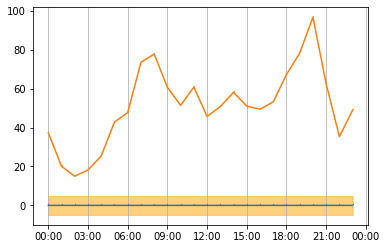

times: (24,)
means: (24,)
sigmas: (24,)


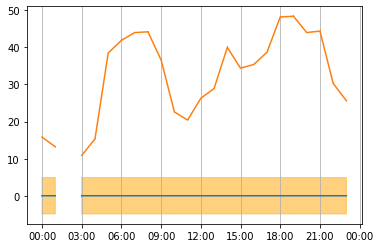

times: (24,)
means: (24,)
sigmas: (24,)


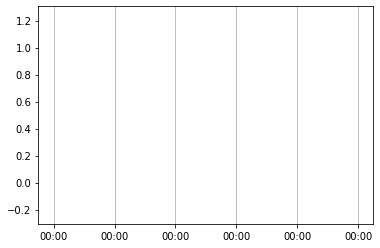

times: (24,)
means: (24,)
sigmas: (24,)


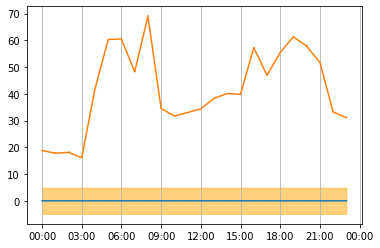

In [47]:
count = 0
for point, row in gb:
    fig0, ax = plt.subplots()
    times = row['measurement_start_utc']
    means = row['predict_mean']
    sigmas = row['predict_var']
    print("times:", times.shape)
    print("means:", means.shape)
    print("sigmas:", sigmas.shape)
    locator = dates.HourLocator(interval=6)
    plot_pretty_timeseries(times, means, ax, sigmas=sigmas, locator=locator)
    plot_pretty_timeseries(times, row['NO2'], ax, locator=locator)
    plt.show()
    count += 1
    if count > 10:
        break

In [32]:
n = 2 # number of rows
c = 2 # number of columns
fig, axs = plt.subplots(n, c, sharex=True, sharey=True)
i = 0
j = 0
for point, row in gb:
    print(point, row['predict_mean'])
    plot_pretty_timeseries(row['measurement_start_utc'], row['predict_mean'], axs[i, j], sigmas=row['predict_var'], locator=dates.HourLocator(interval=6))
    plot_pretty_timeseries(row['measurement_start_utc'], row['NO2'], axs[i, j], locator=dates.HourLocator(interval=6))
    i += j % c
    j += 1
    j = j % c
    if i == n:
        break

0016baa9-b443-47a9-93c0-6ef19de90f37 5904    0.000362
5905    0.000204
5906    0.000240
5907    0.000242
5908    0.000227
5909    0.000176
5910    0.000210
5911    0.000182
5912    0.000162
5913    0.000172
5914    0.000250
5915    0.000397
5916    0.000368
5917    0.000264
5918    0.000313
5919    0.000276
5920    0.000212
5921    0.000209
5922    0.000168
5923    0.000146
5924    0.000118
5925    0.000046
5926    0.000047
5927    0.000028
Name: predict_mean, dtype: float64
03545b62-45cc-40d2-97ef-b8187848ff7f 2040   NaN
2041   NaN
2042   NaN
2043   NaN
2044   NaN
2045   NaN
2046   NaN
2047   NaN
2048   NaN
2049   NaN
2050   NaN
2051   NaN
2052   NaN
2053   NaN
2054   NaN
2055   NaN
2056   NaN
2057   NaN
2058   NaN
2059   NaN
2060   NaN
2061   NaN
2062   NaN
2063   NaN
Name: predict_mean, dtype: float64
048fc820-7d21-40d7-85d6-2cceb3457e05 2712   NaN
2713   NaN
2714   NaN
2715   NaN
2716   NaN
2717   NaN
2718   NaN
2719   NaN
2720   NaN
2721   NaN
2722   NaN
2723   NaN
2724   NaN
2725

RuntimeError: Locator attempting to generate 31887 ticks from 729757.7083333334 to 737729.2083333334: exceeds Locator.MAXTICKS